<img src="https://github.com/hernancontigiani/ceia_memorias_especializacion/raw/master/Figures/logoFIUBA.jpg" width="500" align="center">


# Procesamiento de lenguaje natural
## Modelo de lenguaje con tokenización por palabras

## Alumna Noelia Qualindi | Cohorte 14

### Consigna
- Seleccionar un corpus de texto sobre el cual entrenar el modelo de lenguaje.
- Realizar el pre-procesamiento adecuado para tokenizar el corpus, estructurar el dataset y separar entre datos de entrenamiento y validación.
- Proponer arquitecturas de redes neuronales basadas en unidades recurrentes para implementar un modelo de lenguaje.
- Con el o los modelos que consideren adecuados, generar nuevas secuencias a partir de secuencias de contexto con las estrategias de greedy search y beam search determístico y estocástico. En este último caso observar el efecto de la temperatura en la generación de secuencias.


### Sugerencias
- Durante el entrenamiento, guiarse por el descenso de la perplejidad en los datos de validación para finalizar el entrenamiento. Para ello se provee un callback.
- Explorar utilizar SimpleRNN (celda de Elman), LSTM y GRU.
- rmsprop es el optimizador recomendado para la buena convergencia. No obstante se pueden explorar otros.


In [1]:
import random
import io
import pickle

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from tensorflow import keras
from tensorflow.keras import layers
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, Dropout
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.preprocessing.text import text_to_word_sequence, Tokenizer
from keras.layers import Input, TimeDistributed, CategoryEncoding, SimpleRNN, Dense
from keras.models import Model, Sequential
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.utils import pad_sequences
import requests
import io
import random

### Análisis de Datos

Cantidad de documentos: 2788


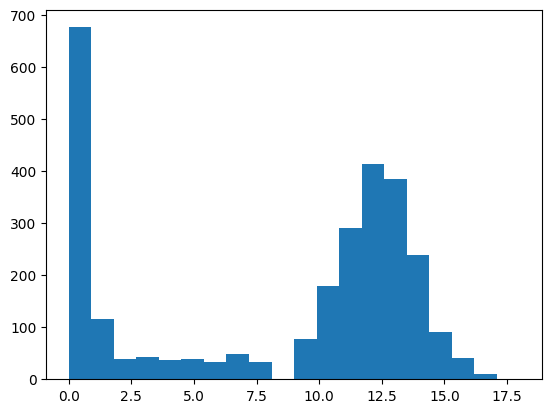

max_context_size: 13


In [31]:
# URL del archivo en GitHub
url = "https://raw.githubusercontent.com/noequalindi/procesamiento_lenguaje_natural/trabajos_practicos_qualindi/trabajos_practicos/desafio_2/orgullo_prejuicio.txt"

# Descargamos el texto
response = requests.get(url)
text_data = response.text.lower()

# Guardamos el texto en un archivo
with open("orgullo_prejuicio.txt", "w", encoding='utf-8') as file:
    file.write(text_data)

# Leemos el archivo de texto en un DataFrame
with open('orgullo_prejuicio.txt', 'r', encoding='utf-8') as file:
    lines = file.readlines()

# Reducimos el tamaño del corpus tomando una muestra aleatoria del 20% de las líneas
sample_size = int(len(lines) * 0.2)
sampled_lines = random.sample(lines, sample_size)

df = pd.DataFrame(sampled_lines, columns=["text"])

print("Cantidad de documentos:", df.shape[0])

# Usaremos las utilidades de procesamiento de textos y secuencias de Keras
text = list(df["text"])

# Segmentamos el texto con la utilidad de Keras
segmented_sentences = [text_to_word_sequence(sentence) for sentence in text]

# Calculamos la longitud de cada secuencia
length_sentences = [len(sentence) for sentence in segmented_sentences]

# Podemos ver su distribución
plt.hist(length_sentences, bins=20)
plt.show()

# Determinamos el tamaño máximo de contexto
max_context_size = int(np.percentile(length_sentences, 90) - 1)
print(f'max_context_size: {max_context_size}')

### Tokenización

In [32]:
# Instanciamos el tokenizador
tok = Tokenizer()

# El tokenizer "aprende" las palabras que se usarán
tok.fit_on_texts(segmented_sentences)

# Convertimos las palabras a números
tokenized_sentences = tok.texts_to_sequences(segmented_sentences)

# Dividimos en conjunto de entrenamiento y validación
tokenized_sentences_train, tokenized_sentences_val, _, _ = train_test_split(tokenized_sentences, tokenized_sentences, test_size=0.2, random_state=42)

# Procesamos las secuencias
tok_sent = []

for sent in tokenized_sentences_train:
    if len(sent) > (max_context_size + 1):
        extra = len(sent) - (max_context_size + 1) + 1
        for i in range(extra):
            tok_sent.append(sent[i:i + max_context_size + 1])
    else:
        tok_sent.append(sent)

tok_sent_augm = []

for sent in tok_sent:
    subseq = [sent[:i + 2] for i in range(len(sent) - 1)]
    tok_sent_augm.append(pad_sequences(subseq, maxlen=max_context_size + 1, padding='pre'))

# Finalmente concatenamos todas las secuencias en un único array de numpy
train_seqs = np.concatenate(tok_sent_augm, axis=0)

# se sacan las entradas y los targets que consumirá nuestro sistema en tiempo de entrenamiento
X = train_seqs[:, :-1]
y = train_seqs[:, 1:]

print(f"Forma de X: {X.shape}")
print(f"Forma de y: {y.shape}")

# Palabras del vocabulario
print(f"Palabras del vocabulario: {tok.index_word}")

# Cantidad de palabras en el vocabulario
vocab_size = len(tok.word_counts)
print(f"Cantidad de palabras en el vocabulario: {vocab_size}")

# El índice para cada palabra
print(f"Índice de cada palabra: {tok.word_index}")

# Cantidad de veces que aparece cada palabra en cada "documento"
print(f"Documentos por palabra: {tok.word_docs}")


Forma de X: (18401, 13)
Forma de y: (18401, 13)
Palabras del vocabulario: {1: 'de', 2: 'que', 3: 'la', 4: 'a', 5: 'y', 6: 'no', 7: 'en', 8: 'el', 9: 'su', 10: 'se', 11: 'con', 12: 'lo', 13: 'por', 14: 'le', 15: 'pero', 16: 'los', 17: 'las', 18: 'para', 19: 'un', 20: 'una', 21: 'elizabeth', 22: 'más', 23: 'al', 24: 'había', 25: 'es', 26: 'sus', 27: 'señor', 28: 'darcy', 29: 'me', 30: 'tan', 31: 'como', 32: 'del', 33: 'bingley', 34: 'era', 35: 'muy', 36: 'señora', 37: 'si', 38: 'mi', 39: 'jane', 40: 'estaba', 41: 'bennet', 42: 'todo', 43: 'él', 44: 'ella', 45: 'señorita', 46: 'usted', 47: 'cuando', 48: 'sin', 49: 'dos', 50: 'ya', 51: 'yo', 52: 'ha', 53: 'nada', 54: 'o', 55: 'lydia', 56: 'todos', 57: 'les', 58: 'poco', 59: 'tiempo', 60: 'ser', 61: 'qué', 62: 'aunque', 63: 'tenía', 64: 'ni', 65: 'sólo', 66: 'antes', 67: 'vez', 68: 'bien', 69: 'dijo', 70: 'habría', 71: 'fue', 72: 'te', 73: 'mucho', 74: 'otra', 75: 'hermana', 76: 'después', 77: 'nunca', 78: 'collins', 79: 'wickham', 80: 'cat

In [3]:
# Definir los hiperparámetros del modelo
embedding_dim = 128
units = 256
batch_size = 64
epochs = 20


## Definición de los modelos

### Modelo Simple RNN

In [4]:
model_rnn = Sequential()

model_rnn.add(Embedding(input_dim=vocab_size+1, output_dim=embedding_dim, input_shape=(max_context_size,)))
model_rnn.add(SimpleRNN(units, return_sequences=True))
model_rnn.add(SimpleRNN(units, return_sequences=True))
model_rnn.add(Dense(vocab_size+1, activation='softmax'))
model_rnn.compile(loss=SparseCategoricalCrossentropy(), optimizer='rmsprop', metrics=['accuracy'])

model_rnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 13, 128)           598016    
                                                                 
 simple_rnn (SimpleRNN)      (None, 13, 256)           98560     
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 13, 256)           131328    
                                                                 
 dense (Dense)               (None, 13, 4672)          1200704   
                                                                 
Total params: 2028608 (7.74 MB)
Trainable params: 2028608 (7.74 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


### Modelo LSTM

In [5]:
model_lstm = Sequential()

model_lstm.add(Embedding(input_dim=vocab_size+1, output_dim=embedding_dim, input_shape=(max_context_size,)))
model_lstm.add(LSTM(units, return_sequences=True))
model_lstm.add(LSTM(units, return_sequences=True))
model_lstm.add(Dense(vocab_size+1, activation='softmax'))
model_lstm.compile(loss=SparseCategoricalCrossentropy(), optimizer='rmsprop', metrics=['accuracy'])

model_lstm.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 13, 128)           598016    
                                                                 
 lstm (LSTM)                 (None, 13, 256)           394240    
                                                                 
 lstm_1 (LSTM)               (None, 13, 256)           525312    
                                                                 
 dense_1 (Dense)             (None, 13, 4672)          1200704   
                                                                 
Total params: 2718272 (10.37 MB)
Trainable params: 2718272 (10.37 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


### Modelo GRU

In [6]:
from keras.layers import GRU
model_gru = Sequential()

model_gru.add(Embedding(input_dim=vocab_size+1, output_dim=embedding_dim, input_shape=(max_context_size,)))
model_gru.add(GRU(units, return_sequences=True))
model_gru.add(GRU(units, return_sequences=True))
model_gru.add(Dense(vocab_size+1, activation='softmax'))
model_gru.compile(loss=SparseCategoricalCrossentropy(), optimizer='rmsprop', metrics=['accuracy'])

model_gru.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 13, 128)           598016    
                                                                 
 gru (GRU)                   (None, 13, 256)           296448    
                                                                 
 gru_1 (GRU)                 (None, 13, 256)           394752    
                                                                 
 dense_2 (Dense)             (None, 13, 4672)          1200704   
                                                                 
Total params: 2489920 (9.50 MB)
Trainable params: 2489920 (9.50 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [35]:
import os
import tensorflow as tf

def save_model(model, model_name, model_dir='models'):
    """
    Guarda el modelo entrenado en la carpeta especificada.

    Args:
        model (tf.keras.Model): El modelo entrenado a guardar.
        model_name (str): El nombre del archivo del modelo.
        model_dir (str): La carpeta donde se guardará el modelo.
    """
    # Verificar si la carpeta existe, si no, crearla
    if not os.path.exists(model_dir):
        os.makedirs(model_dir)

    # Definir la ruta completa del modelo
    model_path = os.path.join(model_dir, model_name)

    # Guardar el modelo
    model.save(model_path)
    print(f'Model saved to {model_path}')


def load_model(model_name, model_dir='models'):
    """
    Carga un modelo desde la carpeta especificada.

    Args:
        model_name (str): El nombre del archivo del modelo.
        model_dir (str): La carpeta desde donde se cargará el modelo.

    Returns:
        tf.keras.Model: El modelo cargado.
    """
    # Definir la ruta completa del modelo
    model_path = os.path.join(model_dir, model_name)

    # Cargar el modelo
    model = tf.keras.models.load_model(model_path)
    print(f'Model loaded from {model_path}')
    return model

In [7]:
class PplCallback(Callback):
    def __init__(self, val_data, history_ppl, model_name, patience=5):
        self.val_data = val_data
        self.target = []
        self.padded = []
        count = 0
        self.info = []
        self.history_ppl = history_ppl
        self.min_score = np.inf
        self.patience_counter = 0
        self.patience = patience
        self.model_name = model_name

        for seq in self.val_data:
            len_seq = len(seq)
            subseq = [seq[:i] for i in range(len_seq)]
            self.target.extend([seq[i] for i in range(len_seq)])
            if len(subseq) != 0:
                self.padded.append(pad_sequences(subseq, maxlen=max_context_size, padding='pre'))
                self.info.append((count, count + len_seq))
                count += len_seq
        self.padded = np.vstack(self.padded)

    def on_epoch_end(self, epoch, logs=None):
        scores = []
        predictions = self.model.predict(self.padded, verbose=0)
        for start, end in self.info:
            probs = [predictions[idx_seq, -1, idx_vocab] for idx_seq, idx_vocab in zip(range(start, end), self.target[start:end])]
            scores.append(np.exp(-np.sum(np.log(probs)) / (end - start)))
        current_score = np.mean(scores)
        self.history_ppl.append(current_score)
        print(f'\n mean perplexity: {current_score} \n')
        if current_score < self.min_score:
            self.min_score = current_score
            save_model(self.model, f'{self.model_name}_epoch_{epoch+1}.h5')
            print("Saved new model!")
            self.patience_counter = 0
        else:
            self.patience_counter += 1
            if self.patience_counter == self.patience:
                print("Stopping training...")
                self.model.stop_training = True

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

def show_plot(history_ppl):
  epoch_count = range(1, len(history_ppl) + 1)
  sns.lineplot(x=epoch_count, y=history_ppl)
  plt.xlabel('Epoch')
  plt.ylabel('Perplexity')
  plt.show()

## Entrenamiento de los modelos Simple RNN, LSTM, GRU

Epoch 1/20
305/305 [==============================] - ETA: 0s - loss: 3.9036 - accuracy: 0.4647
 mean perplexity: 8425.513113265488 

Model saved to models/model_rnn_epoch_1.h5
Saved new model!
305/305 [==============================] - 26s 71ms/step - loss: 3.9036 - accuracy: 0.4647
Epoch 2/20
  3/305 [..............................] - ETA: 9s - loss: 3.5446 - accuracy: 0.4820 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


305/305 [==============================] - ETA: 0s - loss: 3.4060 - accuracy: 0.4881
 mean perplexity: 7796.421059775972 

Model saved to models/model_rnn_epoch_2.h5
Saved new model!
305/305 [==============================] - 13s 42ms/step - loss: 3.4060 - accuracy: 0.4881
Epoch 3/20
305/305 [==============================] - ETA: 0s - loss: 3.1814 - accuracy: 0.4982
 mean perplexity: 9950.314054706927 

305/305 [==============================] - 13s 41ms/step - loss: 3.1814 - accuracy: 0.4982
Epoch 4/20
305/305 [==============================] - ETA: 0s - loss: 3.0078 - accuracy: 0.5077
 mean perplexity: 13593.271779771856 

305/305 [==============================] - 13s 44ms/step - loss: 3.0078 - accuracy: 0.5077
Epoch 5/20
305/305 [==============================] - ETA: 0s - loss: 2.8506 - accuracy: 0.5212
 mean perplexity: 22547.96095382497 

305/305 [==============================] - 12s 40ms/step - loss: 2.8506 - accuracy: 0.5212
Epoch 6/20
305/305 [==============================

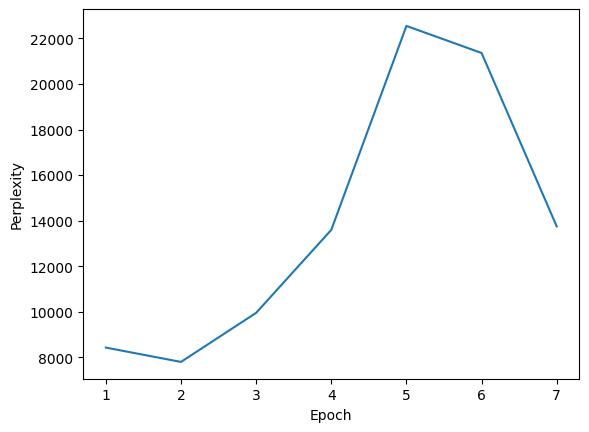

In [10]:
# Entrenamiento del modelo Simple RNN
history_ppl_rnn = []
hist_rnn = model_rnn.fit(X, y, epochs=epochs, callbacks=[PplCallback(tokenized_sentences_val, history_ppl_rnn, model_name='model_rnn')], batch_size=batch_size)

show_plot(history_ppl_rnn)

Epoch 1/20
305/305 [==============================] - ETA: 0s - loss: 4.1379 - accuracy: 0.4628
 mean perplexity: 5558.585740951994 

Model saved to models/model_lstm_epoch_1.h5
Saved new model!
305/305 [==============================] - 15s 37ms/step - loss: 4.1379 - accuracy: 0.4628
Epoch 2/20
 10/305 [..............................] - ETA: 3s - loss: 3.6763 - accuracy: 0.4695

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


305/305 [==============================] - ETA: 0s - loss: 3.6447 - accuracy: 0.4747
 mean perplexity: 6548.995099909521 

305/305 [==============================] - 7s 23ms/step - loss: 3.6447 - accuracy: 0.4747
Epoch 3/20
305/305 [==============================] - ETA: 0s - loss: 3.6054 - accuracy: 0.4756
 mean perplexity: 7206.863086606632 

305/305 [==============================] - 6s 20ms/step - loss: 3.6054 - accuracy: 0.4756
Epoch 4/20
305/305 [==============================] - ETA: 0s - loss: 3.5082 - accuracy: 0.4816
 mean perplexity: 17245.196001840995 

305/305 [==============================] - 7s 23ms/step - loss: 3.5082 - accuracy: 0.4816
Epoch 5/20
305/305 [==============================] - ETA: 0s - loss: 3.4010 - accuracy: 0.4879
 mean perplexity: 10055.697132599083 

305/305 [==============================] - 6s 20ms/step - loss: 3.4010 - accuracy: 0.4879
Epoch 6/20
305/305 [==============================] - ETA: 0s - loss: 3.3227 - accuracy: 0.4930
 mean perplexity:

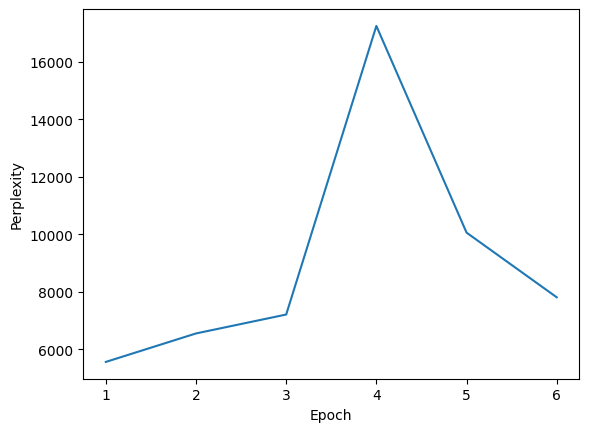

In [11]:
# Entrenamiento del modelo LSTM
history_ppl_lstm = []
hist_lstm = model_lstm.fit(X, y, epochs=epochs, callbacks=[PplCallback(tokenized_sentences_val, history_ppl_lstm, model_name='model_lstm')], batch_size=batch_size)
show_plot(history_ppl_lstm)

Epoch 1/20
305/305 [==============================] - ETA: 0s - loss: 3.8710 - accuracy: 0.4719
 mean perplexity: 8612.380733469912 

Model saved to models/model_gru_epoch_1.h5
Saved new model!
305/305 [==============================] - 15s 39ms/step - loss: 3.8710 - accuracy: 0.4719
Epoch 2/20
  3/305 [..............................] - ETA: 14s - loss: 3.2870 - accuracy: 0.5032

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


305/305 [==============================] - ETA: 0s - loss: 3.3553 - accuracy: 0.4915
 mean perplexity: 9775.508103319477 

305/305 [==============================] - 7s 22ms/step - loss: 3.3553 - accuracy: 0.4915
Epoch 3/20
305/305 [==============================] - ETA: 0s - loss: 3.1873 - accuracy: 0.5039
 mean perplexity: 8245.250853247708 

Model saved to models/model_gru_epoch_3.h5
Saved new model!
305/305 [==============================] - 6s 19ms/step - loss: 3.1873 - accuracy: 0.5039
Epoch 4/20
305/305 [==============================] - ETA: 0s - loss: 3.0503 - accuracy: 0.5165
 mean perplexity: 8937.813907577598 

305/305 [==============================] - 7s 22ms/step - loss: 3.0503 - accuracy: 0.5165
Epoch 5/20
303/305 [============================>.] - ETA: 0s - loss: 2.9360 - accuracy: 0.5258
 mean perplexity: 6342.135496216626 

Model saved to models/model_gru_epoch_5.h5
Saved new model!
305/305 [==============================] - 6s 18ms/step - loss: 2.9362 - accuracy: 0.

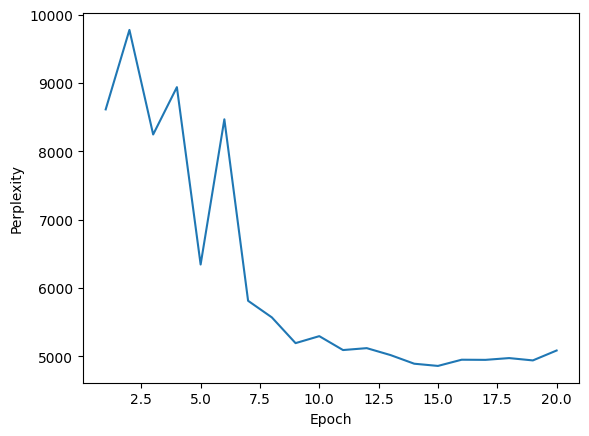

In [12]:
# Entrenamiento del modelo GRU
history_ppl_gru = []
hist_gru = model_gru.fit(X, y, epochs=epochs, callbacks=[PplCallback(tokenized_sentences_val, history_ppl_gru, model_name='model_gru')], batch_size=batch_size)
show_plot(history_ppl_gru)


### Predicción de próxima palabra con cada modelo

In [13]:
def greedy_search_word(model, encoded, tok):
    y_hat = np.argmax(model.predict(encoded)[0, -1, :])
    out_word = ''
    for word, index in tok.word_index.items():
        if index == y_hat:
            out_word = word
            break
    return out_word


def beam_search_word(model, encoded, tok, beam_width=3):
    sequences = [[list(), 1.0]]
    for _ in range(len(encoded[0])):
        all_candidates = list()
        for i in range(len(sequences)):
            seq, score = sequences[i]
            predictions = model.predict(encoded)[0, -1, :]
            for j in range(len(predictions)):
                candidate = [seq + [j], score * -np.log(predictions[j])]
                all_candidates.append(candidate)
        ordered = sorted(all_candidates, key=lambda tup: tup[1])
        sequences = ordered[:beam_width]
    best_seq = sequences[0][0]
    out_word = ''
    for idx in best_seq:
        for word, index in tok.word_index.items():
            if index == idx:
                out_word = word
                break
    return out_word

In [14]:
!pip install -q gradio

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.4/50.4 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 110.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 318.2/318.2 kB 27.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 141.1/141.1 kB 13.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.1/10.1 MB 112.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.8/62.8 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.2/92.2 kB 9.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.9/71.9 kB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.9/129.9 kB 11.9 MB/s eta 0:00:00
   ━━━━━

In [21]:
def get_model_names(model_dir='models'):
    return [f for f in os.listdir(model_dir) if os.path.isfile(os.path.join(model_dir, f))]


In [34]:
import gradio as gr

def model_response_word(human_text, model_name, search_method, model_dir='models'):
    # Cargar el modelo
    model = load_model(model_name, model_dir)

    # Encodeamos
    encoded = tok.texts_to_sequences([human_text])[0]
    encoded = pad_sequences([encoded], maxlen=max_context_size, padding='pre')

    # Selección del método de búsqueda
    if search_method == "greedy":
        out_word = greedy_search_word(model, encoded, tok)
    elif search_method == "beam":
        out_word = beam_search_word(model, encoded, tok)
    else:
        raise ValueError("Método de búsqueda no válido")

    # Agregar la palabra a la frase predicha
    return human_text + ' ' + out_word

# Obtener la lista de modelos
model_names = get_model_names()

iface_word = gr.Interface(
    fn=model_response_word,
    inputs=[
        gr.Textbox(label="Input Text"),
        gr.Dropdown(model_names, label="Model Name"),
        gr.Dropdown(["greedy", "beam"], label="Search Method")
    ],
    outputs="text"
)

iface_word.launch(debug=True)

Setting queue=True in a Colab notebook requires sharing enabled. Setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
Running on public URL: https://c78b80228cd50834c2.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


Model loaded from models/model_gru_epoch_15.h5
1/1 [==============================] - 0s 18ms/step
Model loaded from models/model_gru_epoch_15.h5
1/1 [==============================] - 0s 20ms/step
Model loaded from models/model_gru_epoch_15.h5
1/1 [==============================] - 0s 24ms/step
Model loaded from models/model_gru_epoch_15.h5
1/1 [==============================] - 0s 23ms/step
Model loaded from models/model_gru_epoch_15.h5
1/1 [==============================] - 0s 22ms/step
Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7860 <> https://c78b80228cd50834c2.gradio.live


### Generación de secuencias con cada modelo y diferentes métodos

In [27]:
def get_best_model(model_dir='models'):
    model_files = [f for f in os.listdir(model_dir) if os.path.isfile(os.path.join(model_dir, f))]
    model_dict = {}
    for model_file in model_files:
        model_base_name = "_".join(model_file.split('_')[:-1])  # format 'model_epoch_{epoch_number}.h5'
        epoch_number = int(model_file.split('_')[-1].split('.')[0])
        if model_base_name not in model_dict or model_dict[model_base_name][1] < epoch_number:
            model_dict[model_base_name] = (model_file, epoch_number)
    return [model_dict[key][0] for key in model_dict]

In [28]:
def generate_seq(model, tok, input_text, max_length, n_words, search_method):
    result = input_text
    for _ in range(n_words):
        encoded = tok.texts_to_sequences([result])[0]
        encoded = pad_sequences([encoded], maxlen=max_length, padding='pre')
        if search_method == 'greedy':
            out_word = greedy_search_word(model, encoded, tok)
        elif search_method == 'beam':
            out_word = beam_search_word(model, encoded, tok)
        else:
            raise ValueError("Invalid search method")
        result += ' ' + out_word
    return result

In [30]:
input_text = 'amor que mata'
n_words = 10
model_dir = 'models'

model_names = get_best_model(model_dir)
search_methods = ['greedy', 'beam']

for model_name in model_names:
    model = load_model(model_name, model_dir)
    for search_method in search_methods:
        generated_seq = generate_seq(model, tok, input_text, max_length=max_context_size, n_words=n_words, search_method=search_method)
        print(f'Model: {model_name}, Search Method: {search_method}')
        print(f'Generated Sequence: {generated_seq}\n')

Model loaded from models/model_gru_epoch_15.h5
1/1 [==============================] - 0s 27ms/step
Model: model_gru_epoch_15.h5, Search Method: greedy
Generated Sequence: amor que mata no me casara antes de la casa de que se

1/1 [==============================] - 0s 25ms/step
Model: model_gru_epoch_15.h5, Search Method: beam
Generated Sequence: amor que mata no me casara antes de la casa de que se

Model loaded from models/model_rnn_epoch_2.h5
1/1 [==============================] - 0s 33ms/step
Model: model_rnn_epoch_2.h5, Search Method: greedy
Generated Sequence: amor que mata la señorita bennet que que que que que la que

1/1 [==============================] - 0s 35ms/step
Model: model_rnn_epoch_2.h5, Search Method: beam
Generated Sequence: amor que mata la señorita bennet que que que que que la que

Model loaded from models/model_lstm_epoch_1.h5
1/1 [==============================] - 0s 17ms/step
Model: model_lstm_epoch_1.h5, Search Method: greedy
Generated Sequence: amor que mata 